In [1]:
from astrosite_dataset import AstrositeDataset

dataset_path = '../dataset/recordings'
target_id = 37867
dataset = AstrositeDataset(data_swap_swapset_path, split=str(target_id))

In [2]:
print(dataset[0]['events'][:5])
print(dataset[0]['labelled_events'][:5])

[(  0,  175, 174,  True) (456,  895, 275, False) (568, 1145, 413, False)
 (596, 1093, 246, False) (644,  462, 284,  True)]
[(  0, 175, 174,  True,  0) (728, 177, 173,  True, 26)
 (775, 177, 171,  True, 25) (793, 184, 172,  True,  0)
 (950, 427, 467,  True,  0)]


In [3]:
from spinnaker_loader import EventsLoader

train_loader = EventsLoader(dataset, bins_per_sample=8, sample_time=1000000)

Collect 9 samples that have only 1 satellite label, and only retain the events that are labelled as that satellite.

In [17]:
samples = []
n_samples = 9

for sample in dataset:
    labels = sorted(list(set(sample['labelled_events']['label'])))
    if labels[0] < -1:
        print(f"Skipping sample with labels {labels}")
        continue
    
    events = sample['labelled_events']
    sat_events = events[events['label'] == -1]
    if len(sat_events) > 320:
        samples.append(sat_events)
    if len(samples) >= n_samples:
        break

Skipping sample with labels [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]
Skipping sample with labels [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


In [19]:
len(samples)


9

In [20]:
import numpy as np

side_length = np.sqrt(n_samples).astype(int)
max_x = 1280
max_y = 720

for i in range(side_length):
    for j in range(side_length):
        index = i*side_length+j
        x_shift = max_x*j
        y_shift = max_y*i
        samples[index]['x'] += x_shift
        samples[index]['y'] += y_shift

merged_events = np.concatenate(samples)
merged_events = np.sort(merged_events, order='t')

In [21]:
import event_stream

encoder = event_stream.Encoder('merged_events.es', 'dvs', 1280*side_length, 720*side_length)

In [22]:
encoder.write(merged_events)

In [1]:
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/jules/Documents/satellite-characterization')
import torch
import torchvision
import numpy as np
from pathlib import Path
from tqdm import tqdm
from astrosite_dataset import build_merge_dataset, MergedDataset
from models.scnn_tracker import MotionTrackerStaticSNN

/home/jules/miniconda3/envs/satellite/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tau_mem1 = 0.2
tau_mem2 = 0.4
tau_mem3 = 0.6
train_mem = False

dataset_path = '/home/jules/Documents/filtered_dataset/recordings'
target_list = ['50574']
dataset = build_merge_dataset(dataset_path, split=target_list, metadata_paths=[None, None], crop=False)
print(dataset[0][0].shape)

Expected size: 95.0
Event density: 11356.545263157896
(10, 2, 144, 256)


In [3]:
net = MotionTrackerStaticSNN(144, 256,  tau_mem1, tau_mem2, tau_mem3,
        train_mem=train_mem)

model_path = 'model.pt'
net.load_state_dict(torch.load('./data/dynamic_tau/' + model_path))

#device = torch.device("cuda") if torch.cuda.is_available() \
#    else torch.device("cpu")
device = torch.device("cpu")
print("Using device:", device)
net = net.to(device)

Using device: cpu


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..6.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..6.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..6.0].


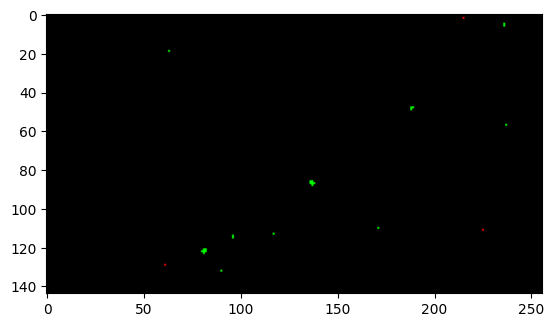

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..6.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..6.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..5.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..10.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..5.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..6.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..7.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for

In [4]:
import matplotlib.animation as animation

input_pictures = []
output_pictures = []

fig, ax = plt.subplots()

def update(i):
    im.set_array(input_pictures[i])
    return im, 

for j in range(1):
    input, target = dataset[j]
    if len(input.shape)==1:
        print(j)
    else :
        for i in range(input.shape[0]) :
            input_picture = np.concatenate((input[i], np.zeros((1,input[i].shape[1],input[i].shape[2]))), axis=0).swapaxes(0,2).swapaxes(0,1)
            input_pictures.append(input_picture)
        #cv2.imshow("satellite",target[0])
        output = net(torch.from_numpy(input).type(torch.float).unsqueeze(0).to(device))
        sum_output = np.sum(output.detach().cpu().numpy(), axis=0)[0][0]
        #cv2.imshow("prediction",sum_output)
        #cv2.waitKey(10)

# Set the initial image
im = ax.imshow(input_pictures[0], animated=True)

# Create the animation object
animation_fig = animation.FuncAnimation(fig, update, frames=len(input_pictures), interval=200, blit=True,repeat_delay=1)

# Show the animation
plt.show()

animation_fig.save("animated_input.gif")

(2, 144, 256)
(1, 144, 256)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2242.0].


(2, 144, 256)
(1, 144, 256)
(2, 144, 256)
(1, 144, 256)
(2, 144, 256)
(1, 144, 256)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..9.0].


(2, 144, 256)
(1, 144, 256)


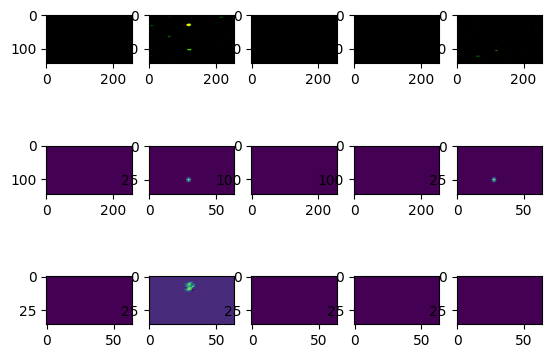

In [6]:
fig, axs = plt.subplots(3,5)#, figsize=(100,100))
h,w = dataset[0][0].shape[2], dataset[0][0].shape[3]
count_non_null = 0
while(count_non_null<5):
    random_idx = np.random.randint(0,len(dataset))
    input, target = dataset[random_idx]
    if len(input.shape)==1 :
        print("wrong shape:",random_idx)
    #elif np.max(input)==0:
    #    print("null sample", random_idx)
    else :
        norm_input = np.sum(input, axis=0)
        print(norm_input.shape)
        print(np.zeros((1,h,w)).shape)
        input_picture = np.concatenate((norm_input, np.zeros((1,h,w))), axis=0).swapaxes(0,2).swapaxes(0,1)
        axs[0,count_non_null].imshow(input_picture)
        axs[1,count_non_null].imshow(target[0])
        output = net(torch.from_numpy(input).type(torch.float).unsqueeze(0).to(device))
        sum_output = np.sum(output.detach().cpu().numpy(), axis=0)[0][0]
        axs[2,count_non_null].imshow(sum_output)
        count_non_null +=1
plt.show()

In [6]:
acc = 0
f_p = 0
f_n = 0
for j in range(len(dataset)) :
    detection_input, detection_target = dataset[j]
    detection_output = net(torch.from_numpy(detection_input).type(torch.float).unsqueeze(0).to(device))
    #print(np.max(detection_output.detach().cpu().numpy()))
    #print(np.max(detection_target))
    if np.max(detection_output.detach().cpu().numpy()) < 0.068 and np.max(detection_target) == 0:
        acc+=1
    elif np.max(detection_output.detach().cpu().numpy()) < 0.068:
        f_n += 1
    elif np.max(detection_target) == 0 :
        f_p += 1
    else :
        acc +=1
print("Detection_accuracy:",acc/len(dataset))
print("False positive:",f_p/len(dataset))
print("False negative:",f_n/len(dataset))


Detection_accuracy: 1.0
False positive: 0.0
False negative: 0.0
0.6666666666666666
0.6666666666666666


In [7]:
from astrosite_dataset import EgoMotionDataset
from experiments.tracking_training import get_keypoint
import numpy as np

period_sim=1000
period=100
generated_dataset = EgoMotionDataset(1e4, 100,60, velocity=((10) / np.array(
            [10 * 1.2,10])), period=period, 
            period_sim=period_sim, n_objects=np.random.randint(15,high=30), obj_size = 2, label=1)

Using device: cuda


In [8]:
from models.scnn_tracker import MotionTrackerStaticSNN
import torch

tau_mem1 = 0.2
tau_mem2 = 0.4
tau_mem3 = 0.6
train_mem = False

net = MotionTrackerStaticSNN(40, 60,  tau_mem1, tau_mem2, tau_mem3,
        train_mem=train_mem)

model_path = '20240718_0734model_generated_crop_1e-4lr.pt'
net.load_state_dict(torch.load('./data/dynamic_tau/' + model_path))

#device = torch.device("cuda") if torch.cuda.is_available() \
#    else torch.device("cpu")
device = torch.device("cpu")
print("Using device:", device)
net = net.to(device)

Using device: cpu


/home/jules/Documents/satellite-characterization/models/scnn_tracker.py:103: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  torch.nn.init.kaiming_uniform(self.conv1.weight)
/home/jules/Documents/satellite-characterization/models/scnn_tracker.py:112: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  torch.nn.init.kaiming_uniform(self.conv2.weight)
/home/jules/Documents/satellite-characterization/models/scnn_tracker.py:121: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  torch.nn.init.kaiming_uniform(self.conv3.weight)


(10, 2, 40, 60)


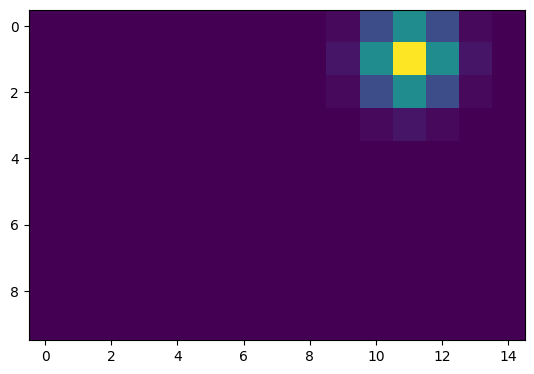

In [9]:
input, target = generated_dataset[0]
print(input.shape)
import matplotlib.pyplot as plt
plt.imshow(target[0])

(1, 10, 15)
torch.Size([1, 10, 2, 40, 60])
10
10


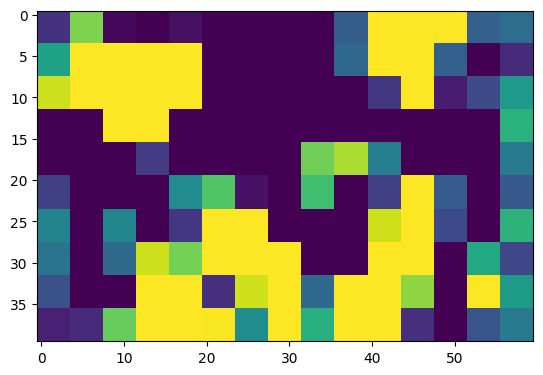

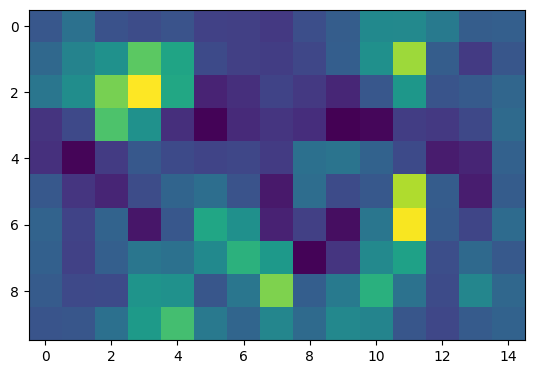

In [5]:
import matplotlib.animation as animation

input_pictures = []
output_pictures = []

fig, ax = plt.subplots()

def update(i):
    im.set_array(input_pictures[i])
    return im, 

def update_output(i):
    im.set_array(output_pictures[i])
    return output_im, 

large_input, target = generated_dataset[2]
print(target.shape)
for j in range(1):
    input = large_input[j*10:(j+1)*10]
    for i in range(input.shape[0]) :
        input_picture = np.concatenate((input[i], np.zeros((1,input[i].shape[1],input[i].shape[2]))), axis=0).swapaxes(0,2).swapaxes(0,1)
        input_pictures.append(input_picture)
    #cv2.imshow("satellite",target[0])
    input = torch.tensor(input).type(torch.float)
    print(input.unsqueeze(0).shape)
    output = net(input.unsqueeze(0).to(device))
    sum_output = np.sum(output.detach().cpu().numpy(), axis=0)[0][0]
    output_pictures.append(sum_output)
    #cv2.imshow("prediction",sum_output)
    #cv2.waitKey(10)

# Set the initial image
im = ax.imshow(input_pictures[0], animated=True)

# Create the animation object
print(len(input_pictures))
animation_fig = animation.FuncAnimation(fig, update, frames=len(input_pictures), interval=200, blit=True,repeat_delay=1,)

out_fig, out_ax = plt.subplots()
output_im = out_ax.imshow(output_pictures[0], animated=True)
# Set the initial image

# Create the animation object

print(len(input_pictures))
output_fig = animation.FuncAnimation(out_fig, update_output, frames=len(output_pictures), interval=2, blit=True,repeat_delay=1,)
# Show the animation
animation_fig.save("animated_input_generated_1.gif")
output_fig.save("animated_output_generated_1.gif")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.0].


(2, 40, 60)
torch.Size([1, 10, 2, 40, 60])
(2, 40, 60)
torch.Size([1, 10, 2, 40, 60])
(2, 40, 60)
torch.Size([1, 10, 2, 40, 60])
(2, 40, 60)
torch.Size([1, 10, 2, 40, 60])
(2, 40, 60)
torch.Size([1, 10, 2, 40, 60])


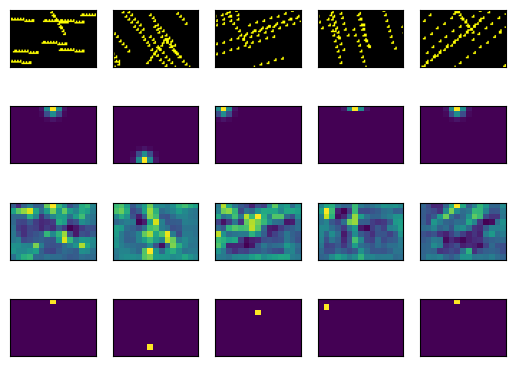

In [30]:
import utils
plt.close("all")
period_sim=1000
period=100
generated_dataset = EgoMotionDataset(1e4, 100,60, velocity=((10) / np.array(
            [10 * 1.2,10])), period=period, 
            period_sim=period_sim, n_objects=np.random.randint(15,high=30), obj_size = 2, label=1)
#plt.figure(figsize=(500,500))
fig, axs = plt.subplots(4,5) #, figsize=(500,500))
h,w = generated_dataset[0][0].shape[2], generated_dataset[0][0].shape[3]
count_non_null = 0
while(count_non_null<5):
    random_idx = np.random.randint(0,len(generated_dataset))
    input, target = generated_dataset[random_idx]
    if len(input.shape)==1 :
        print("wrong shape:",random_idx)
    else :
        norm_input = np.sum(input, axis=0)
        print(norm_input.shape)
        input_picture = np.concatenate((norm_input, np.zeros((1,h,w))), axis=0).swapaxes(0,2).swapaxes(0,1)
        axs[0,count_non_null].imshow(input_picture)
        axs[0,count_non_null].get_xaxis().set_visible(False)
        axs[0,count_non_null].get_yaxis().set_visible(False)
        axs[1,count_non_null].imshow(target[0])
        axs[1,count_non_null].get_xaxis().set_visible(False)
        axs[1,count_non_null].get_yaxis().set_visible(False)
        print(torch.from_numpy(input).type(torch.float).unsqueeze(0).shape)
        output = net(torch.from_numpy(input).type(torch.float).unsqueeze(0).to(device))
        sum_output = np.sum(output.detach().cpu().numpy(), axis=0)[0][0]
        y,x = get_keypoint(sum_output)
        axs[2,count_non_null].imshow(sum_output)
        axs[2,count_non_null].get_xaxis().set_visible(False)
        axs[2,count_non_null].get_yaxis().set_visible(False)
        max_point = np.zeros(sum_output.shape)
        max_point[x,y] = 1
        axs[3,count_non_null].imshow(max_point)
        axs[3,count_non_null].get_xaxis().set_visible(False)
        axs[3,count_non_null].get_yaxis().set_visible(False)
        count_non_null +=1
plt.show()

In [1]:
import nir
import snntorch as snn
import nirtorch
from astrosite_dataset import EgoMotionDataset
import numpy as np


/home/jules/miniconda3/envs/satellite/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from models.scnn_detection import MotionDetectionSNN
import torch
import snntorch as snn

tau_mem1 = 0.2
tau_mem2 = 0.4
tau_mem3 = 0.6
v_th_1 = 0.6
v_th_2 = 0.5
v_th_3 = 0.4
train_mem = False

net = MotionDetectionSNN(40, 60, 1, tau_mem1, tau_mem2, tau_mem3,
                         v_th_1, v_th_2, v_th_3,
                                train_mem=train_mem)

state_dict = torch.load('model_detection.pt')
for k in state_dict.keys():
       print(k)
net.load_state_dict(state_dict)

#device = torch.device("cuda") if torch.cuda.is_available() \
#    else torch.device("cpu")
device = torch.device("cpu")
print("Using device:", device)
net = net.to(device)

conv1.weight
lif1.threshold
lif1.graded_spikes_factor
lif1.reset_mechanism_val
lif1.beta
conv2.weight
lif2.threshold
lif2.graded_spikes_factor
lif2.reset_mechanism_val
lif2.beta
linear1.weight
lif3.threshold
lif3.graded_spikes_factor
lif3.reset_mechanism_val
lif3.beta
linear2.weight
li.threshold
li.graded_spikes_factor
li.reset_mechanism_val
li.beta
Using device: cpu


In [3]:
period_sim=2000
period=100
detection_generated_dataset = EgoMotionDataset(1e4, 100,60, velocity=((period_sim / period) / np.array(
            [period_sim / period * 1.2, period_sim / period])), period=period, 
            period_sim=period_sim, n_objects=np.random.randint(15,high=30), obj_size = 2, label=1)

input = detection_generated_dataset[0][0]
print(torch.from_numpy(input).type(torch.float)[:,0].unsqueeze(0).unsqueeze(2).shape)
input_detection = torch.from_numpy(input).type(torch.float)[:,0].unsqueeze(0).unsqueeze(2)[:,0]
print(input_detection.shape)
nir_graph = snn.export_to_nir(net, input_detection, "tracking")
print([node for node in nir_graph.nodes])
#print(nir_graph.nodes['conv1'].input_type )
print(nir_graph.nodes['input'].output_type )
print(nir_graph.nodes['linear1'].input_type)
print(nir_graph.nodes['linear1'].output_type)
print(nir_graph.nodes['linear2'].input_type)
print(nir_graph.nodes['linear2'].output_type)
nir_graph.nodes['input'].output_type = {'output': np.array((1, 40,60))}
nir_graph.nodes['conv1'].input_shape = {'input_shape': np.array((1, 40,60))}
#nir_graph.nodes['conv1'].output_type = {'input': np.array((8, 40,60))}
nir_graph.nodes['pool1'].input_type = {'input': np.array((8,40,60))}
nir_graph.nodes['pool1'].output_type = {'output': np.array((8, 20,30))}
nir_graph.nodes['lif1'].input_type = {'input': np.array((8, 20,30))}
nir_graph.nodes['lif1'].output_type = {'output': np.array((8, 20,30))}
nir_graph.nodes['conv2'].input_shape = {'input_shape': np.array((8, 20,30))}
#nir_graph.nodes['conv2'].output_type = {'output': np.array((32, 20,30))}
nir_graph.nodes['pool2'].input_type = {'input': np.array((32,20,30))}
nir_graph.nodes['pool2'].output_type = {'output': np.array((32, 10,15))}
nir_graph.nodes['lif2'].input_type = {'input': np.array((1, 10,15))}
nir_graph.nodes['lif2'].output_type = {'output': np.array((1, 10,15))}
print(nir_graph.nodes['conv1'].input_type )
print(nir_graph.nodes['pool1'].input_type )
print(nir_graph.nodes['pool1'].output_type )


""" nir_graph.nodes['lif1'].metadata = {None}
nir_graph.nodes['lif2'].metadata = {None}
nir_graph.nodes['lif3'].metadata = {None}
nir_graph.nodes['li'].metadata = {None} """
#nir_graph.infer_types()

torch.Size([1, 20, 1, 40, 60])
torch.Size([1, 1, 40, 60])
input: torch.Size([1, 4800])
weights: torch.Size([100, 4800])
LINEAR NUMBER 2 COMING
input: torch.Size([1, 100])
weights: torch.Size([1, 100])
['input', 'conv1', 'pool1', 'lif1', 'conv2', 'pool2', 'lif2', 'linear1', 'lif3', 'linear2', 'li', 'output']
{'output': array([ 1,  1, 40, 60])}
{'input': array([4800])}
{'output': (100,)}
{'input': array([100])}
{'output': (1,)}
{'input': None}
{'input': array([ 8, 40, 60])}
{'output': array([ 8, 20, 30])}


" nir_graph.nodes['lif1'].metadata = {None}\nnir_graph.nodes['lif2'].metadata = {None}\nnir_graph.nodes['lif3'].metadata = {None}\nnir_graph.nodes['li'].metadata = {None} "

In [4]:
for node in nir_graph.nodes:
    print(node)
print(nir_graph)
nir.write("detection_satellite_graph.nir", nir_graph) 

input
conv1
pool1
lif1
conv2
pool2
lif2
linear1
lif3
linear2
li
output
NIRGraph(nodes={'input': Input(input_type={'input': array([ 1,  1, 40, 60])}), 'conv1': Conv2d(input_shape={'input_shape': array([ 1, 40, 60])}, weight=array([[[[ 0.22081597,  0.28463614,  0.07702412,  0.14422885,
           0.24785091],
         [ 0.1912879 ,  0.16782384,  0.33453268,  0.24479301,
           0.3471725 ],
         [ 0.09726386,  0.07032064,  0.02521005,  0.14316824,
           0.17893612],
         [ 0.13624583,  0.19154483,  0.24811465,  0.06098385,
           0.15103401],
         [ 0.23248085,  0.27964726,  0.07352188,  0.28991374,
           0.08581349]]],


       [[[ 0.0937479 ,  0.3414591 , -0.00058577,  0.14375012,
           0.1274157 ],
         [ 0.09229816,  0.33549237,  0.04335251,  0.15911351,
           0.14144124],
         [ 0.02971317,  0.0529996 ,  0.30022517,  0.28700885,
           0.3766953 ],
         [ 0.23205946,  0.04210199,  0.15156594,  0.01163752,
           0.21654382],

In [5]:
test_graph = nir.read("detection_satellite_graph.nir")
print(test_graph)

{'edges': array([[b'input', b'conv1'],
       [b'conv1', b'lif1'],
       [b'pool1', b'conv2'],
       [b'li', b'output'],
       [b'lif1', b'pool1'],
       [b'pool2', b'output'],
       [b'conv2', b'lif2'],
       [b'lif3', b'linear2'],
       [b'linear2', b'li'],
       [b'lif2', b'pool2'],
       [b'linear1', b'lif3']], dtype=object), 'nodes': {'conv1': {'bias': array([0., 0., 0., 0., 0., 0., 0., 0.]), 'dilation': array([1, 1]), 'groups': 1, 'input_shape': {'input_shape': array([ 1, 40, 60])}, 'padding': array([2, 2]), 'stride': array([1, 1]), 'type': 'Conv2d', 'weight': array([[[[ 0.22081597,  0.28463614,  0.07702412,  0.14422885,
           0.24785091],
         [ 0.1912879 ,  0.16782384,  0.33453268,  0.24479301,
           0.3471725 ],
         [ 0.09726386,  0.07032064,  0.02521005,  0.14316824,
           0.17893612],
         [ 0.13624583,  0.19154483,  0.24811465,  0.06098385,
           0.15103401],
         [ 0.23248085,  0.27964726,  0.07352188,  0.28991374,
           0

TypeError: tuple must be int or np.ndarray, not <class 'dict'>

In [6]:
sinabs = nir.read('cnn_sinabs.nir')
print(sinabs)
nir.write("cnn_sinabs_test.nir",sinabs)

{'edges': array([[b'8', b'9'],
       [b'11', b'12'],
       [b'5', b'6'],
       [b'0', b'1'],
       [b'9', b'10'],
       [b'12', b'output'],
       [b'4', b'5'],
       [b'3', b'4'],
       [b'2', b'3'],
       [b'input', b'0'],
       [b'6', b'7'],
       [b'1', b'2'],
       [b'7', b'8'],
       [b'10', b'11']], dtype=object), 'nodes': {'0': {'bias': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), 'dilation': array([1, 1]), 'groups': 1, 'input_shape': array([34, 34]), 'padding': array([1, 1]), 'stride': array([2, 2]), 'type': 'Conv2d', 'weight': array([[[[-2.57342190e-01, -2.70349383e-01, -3.26558143e-01,
          -4.17663515e-01, -9.88097265e-02],
         [ 2.34425128e-01,  1.16054296e-01, -2.71869171e-02,
           1.57199875e-01,  2.33631223e-01],
         [ 1.71217293e-01,  2.93264687e-01,  1.91531390e-01,
           2.45372713e-01,  1.19963460e-01],
         [-9.01643708e-02,  1.56642780e-01,  1.54429510e-01,
          -3.5176

(5, 314)
['0.16758808493614197' '0.11479964107275009' '0.10431251674890518'
 '0.0944855809211731' '0.0840994268655777' '0.07228565961122513'
 '0.061173807829618454' '0.0518588088452816' '0.04530607536435127'
 '0.040801890194416046']


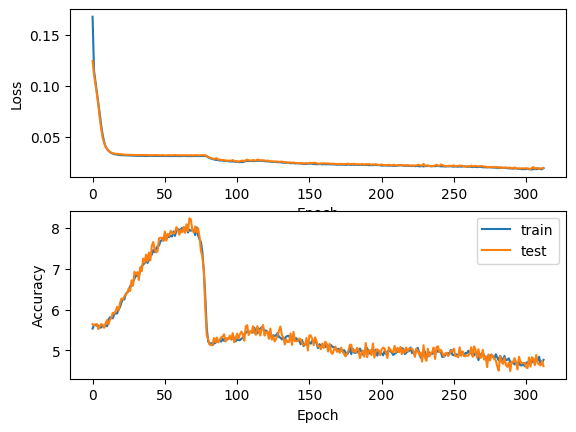

In [58]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
def plot(path):
    data = np.loadtxt(path,delimiter=";", dtype=str)
    data_swap = np.transpose(data)
    print(data_swap.shape)

    fig, ax = plt.subplots(nrows=2)
    # Acc
    print(data_swap[1][1:11])
    ax[0].plot([float(i) for i in data_swap[1][1:]], label="train")
    ax[0].plot([float(i) for i in data_swap[3][1:]], label="test")
    ax[0].set_ylabel("Loss")
    ax[0].set_xlabel("Epoch")
    ax[1].plot([float(i) for i in data_swap[2][1:]], label="train")
    ax[1].plot([float(i) for i in data_swap[4][1:]], label="test")
    ax[1].set_ylabel("Accuracy")
    ax[1].set_xlabel("Epoch")
    ax[1].legend()
    plt.savefig(path.parent / "data.png")
if __name__ == "__main__":
    data_path = Path("data/dynamic_tau/data20240718_0734model_generated_crop_1e-4lr.csv")
    plot(data_path)